# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
import my_credentials
import pyaudio
from bs4 import BeautifulSoup
import requests
import io
import os
import numpy as np
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders as Encoders
from email.utils import COMMASPACE, formatdate
import wave

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = my_credentials.PATH_TO_API_KEY

In [7]:
class Monty:
    
    def __init__(self):
        pass
    
    def help_me(self):
        """records and transcribes the audio, then decides which of the three
        functionalities, if any, to execute
        """
        filename = '/home/hayley/bounds_ay250_homework/hw_3/temp.wav'
        self.record_audio(filename)
        transcript  = self.transcribe_file(filename)
        if 'email' in transcript or 'mail' in transcript:
            self.send_mail(transcript)
        elif 'joke' in transcript:
            self.tell_joke()
        elif 'calculate' in transcript:
            self.do_math_num_chars(transcript)
        else:
            print('I dont recognize the command. Please tell me to send email, ' +
                  'tell a joke, or calculate something')
    
        
    def record_audio(self, filename):
        """record audio and save it to a wav file w/name filename"""
        chunk = 1024
        FORMAT = pyaudio.paInt16
        CHANNELS = 1
        RATE = 44100
        RECORD_SECONDS = 8
        WAVE_OUTPUT_FILENAME = filename
        p = pyaudio.PyAudio()
        stream = p.open(format = FORMAT,
            channels = CHANNELS,
            rate = RATE,
            input = True,
            frames_per_buffer = chunk)
        all = []
        for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
            data = stream.read(chunk)
            all.append(data)
        print("* done recording")
        stream.close()
        p.terminate()
        data = b"".join(all)
        wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(data)
        wf.close()
    
    def transcribe_file(self, speech_file):
        """Taken from the google speech python example docs.
        Transcribes a given audio file"""
        client = speech.SpeechClient()
        with io.open(speech_file, 'rb') as audio_file:
            content = audio_file.read()

        audio = types.RecognitionAudio(content=content)
        config = types.RecognitionConfig(
            encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
            sample_rate_hertz=44100,
            language_code='en-US')
        response = client.recognize(config, audio)
        for result in response.results:
            # The first alternative is the most likely one for this portion.
            print('I think you said: {}'.format(result.alternatives[0].transcript))
        return result.alternatives[0].transcript
    
    def send_mail(self, transcript):
        """sends mail based on text of transcript. Assume that body and subject
        contents are the words coming after subject and body, as in the command
        'Send email with subject ___ and body ___'. Does not assume an order of
        subject and body.
        Creates the strings for subject and body contents, then passes them and
        the user credentials to mail to handle the actual mailing.
        """
        #break up the transcript into a list of words
        t = transcript.split()
    
        #search for something indicating where the subject begins
        try:
            subjind = t.index('subject')
        except: 
            try:
                subjind = t.index('Subject')
            except:
                print('no subject found!')
                return
        #search for something indicating where body begins
        try:
            bodyind = t.index('body')
        except: 
            try:
                bodyind = t.index('Body')
            except:
                print('no body found!')
                return    
            
        if subjind < bodyind:
            #all words after subject but before body are subject contents
            subject_text = [s for i, s in enumerate(t) if i > subjind and i < bodyind]
            #if the last word before body was and, as in 'subject __ and body __', ignore it
            if subject_text[len(subject_text)-1] == 'and':
                subject_text.pop(len(subject_text)-1)
            #all words after body are body contents
            body_text = [s for i, s in enumerate(t) if i > bodyind]
        else:
            subject_text = [s for i, s in enumerate(t) if i > subjind]
            body_text = [s for i, s in enumerate(t) if i > bodyind and i < subjind]
            #if the last word before subject was and, as in 'subject __ and body __', ignore it
            if body_text[len(body_text)-1] == 'and':
                body_text.pop(len(body_text)-1)
        
        #turn the lists into single strings
        subject_text = ' '.join(subject_text)
        body_text = ' '.join(body_text)

        self.mail(my_credentials.GMAIL_USER, my_credentials.GMAIL_PW,
             my_credentials.GMAIL_RECIPIENT, subject_text, body_text)
        
        
    def mail(self, sender, pwd, to, subject, text, files=[]):
        """Function that actually sends the mail. 'Borrowed' from the
        in class notebook."""
        msg = MIMEMultipart()
        msg["From"] = sender
        msg["To"] = COMMASPACE.join(to)
        msg["Date"] = formatdate(localtime=True)
        msg["Subject"] = subject
        msg.attach(MIMEText(text))
        for file in files:
            part = MIMEBase("application", "octet-stream")
            part.set_payload( open(file,"rb").read() )
            Encoders.encode_base64(part)
            part.add_header("Content-Disposition", "attachment; filename='%s'"
                           % os.path.basename(file))
            msg.attach(part)
        # Note that we need to designate the remote SMTP server we want to use.
        mailServer = smtplib.SMTP(my_credentials.SMTP_SERVER, my_credentials.SMTP_NUMBER)
        mailServer.starttls()
        mailServer.login(sender, pwd)
        mailServer.sendmail(sender, to, msg.as_string())
        mailServer.close()
        
    def tell_joke(self):
        """get the html from a website of jokes, then randomly select one
        """
        jokes_req = requests.get(
            "http://www.quickfunnyjokes.com/funnythoughts.html")
        soup = BeautifulSoup(jokes_req.text,"html.parser")
        #all but the last item surrounded by span are joke sections, but the first and last two are weirdly formatted, so skip them
        joke_secs = soup.findAll('span')[1:len(soup.findAll('span'))-4]
        #convert this to list of lists of jokes, and convert from beautifulsoup navigable string type to a normal string
        jokes_as_strings = [[str(s) for s in sec.contents] for sec in joke_secs]
        #then randomly select one of the 4 joke sections
        selection = np.random.randint(0,4)
        #every fourth element is a joke string, the others are formatting 
        joke_array = np.asarray(jokes_as_strings[selection])[0:len(jokes_as_strings[1])-1:4]
        #get rid of some weird leftover formatting
        joke_array = [s.replace('\n','') for s in joke_array]
        joke_array = [s.replace('â',"'") for s in joke_array]
        joke_array = [s.replace('â¦',"...") for s in joke_array]
        #and then select a random joke from that subset of jokes
        print(joke_array[np.random.randint(0, len(joke_array))])
    
    def do_math_num_chars(self, transcript):
        """input: a transcript indicating a mathematical operation to be done
        where numbers are represented as numeric characters like '1'
        output: the result of that operation
        Logic: for simple calculations, google speech to text returns a string that
        can be understood by eval. For more complex wording or things like the 
        square root, google speech to text returns words. So first I try to use the
        eval function, and if it gives an error, then I run through and try to figure
        out what the user might have asked. The two main cases are those where the
        operation comes first (divide two by four) or is in the middle
        (two divided by four). Within those try to break down logical ways to figure
        out what was asked.
        """
        #convert transcript to a list of words
        t = transcript.split()
        #remove 'the'
        t = [s for s in t if s!='the']
        #if the first word is monty or calculate, ignore it
        if t[0] == 'monty' or t[0] == 'Monty' or t[0] == 'Monte':
            t.pop(0)
        if t[0] == 'calculate' or t[0] == 'Calculate':
            t.pop(0)

        #Google speech automatically converts most things to something understood
        #by eval
        t = [s if s!='^' else '**' for s in t ] #change ^ to **
        try:
            print(eval(' '.join(t)))
            return eval(' '.join(t))
        except: #if it doesn't understand it, continue to my logic
            pass

        #decide if the first word is a operation, as in the case of
        #'add _ and _' or 'square'
        operations_words = ['divide', 'add', 'sum', 'subtract', 'multiply', 'square root', 'square']
        if t[0] in operations_words:
            #in the case of square root or square, the next words should always be numbers
            if t[0] == 'square':
                t.pop(0)
                if t[0] == 'root':
                    t.pop(0)
                    if t[0] == 'of':
                        t.pop(0)
                    #the next word should be the number
                    n = int(t[0])
                    print(np.sqrt(n))
                    return np.sqrt(n)
                else:
                    #next word should be the number
                    n = int(t[0])
                    print(n**2)
                    return n**2
            #for add and subtract, expect the numbers to be separated by 'and'
            if t[0] == 'add' or t[0] == 'sum' or t[0] == 'subtract':
                op = t.pop(0)
                if t[0] == 'of': #in the case of sum off
                    t.pop(0)
                ind = t.index('and')
                n1 = int(t[ind-1])
                n2 =  int(t[ind+1])
                if op == 'add' | op == 'sum':
                    print(n1+n2)
                    return n1+n2
                else:
                    print(n1-n2)
                    return n1-n2
            #for divide and multiply, expect them to be separated by 'by'
            if t[0] == 'divide' or t[0] == 'multiply':
                op = t.pop(0)
                ind = t.index('by')
                n1 = int(t[ind-1])
                n2 =  int(t[ind+1])
                if op == 'multiply':
                    print(n1*n2)
                    return n1*n2
                else:
                    print(n1/n2)
                    return n1/n2

        #otherwise, if the first word is a number, we need to search for the operation 
        else:
            operation_words = ['divided', 'times', 'multiplied', 'plus', 'minus', 'squared', 'to']
            #find which operation word is in t
            op = [s for s in t if s in operation_words]
            if len(op) > 1:
                raise Exception('Monty can only do one operation at a time, sorry')
            if len(op) == 0:
                raise Exception('No operation detected.')
            op=op[0]#get op out of list form
            #in the case of squared, expect that to end the string
            if op == 'squared':
                ind = t.index(op)
                n = int(t[0])
                print(n**2)
                return n**2
        
            #otherwise, remove extraneous words (including power in the case of to the power of)
            t = [s for s in t if s not in ['and', 'by', 'of', 'power']]
            #then find where the operation is, as it likely splits the two numbers
            ind = t.index(op)
            n1 = int(t[0])
            n2 = int(t[ind+1])
            if op == 'divided':
                print(n1/n2)
                return n1/n2
            if op == 'times' or op == 'multiplied':
                print(n1*n2)
                return n1*n2
            if op == 'plus':
                print(n1+n2)
                return n1+n2
            if op == 'minus':
                print(n1-n2)
                return n1-n2
            if op == 'to':
                print(n1**n2)
                return n1**n2


In [10]:
monty = Monty()
monty.help_me()

* done recording
I think you said: calculate square root of 4
2.0


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import aifc 
import math
#get all normal audio files
audio_files = glob.glob('/home/hayley/sound_files/*.aif')
#I put the organ files in a subfolder, get those too
organ_files = glob.glob('/home/hayley/sound_files/organs/*.aif')

One note found in file /home/hayley/sound_files/organs/F3_PopOrgan.aif : F3 w/freq 173.875


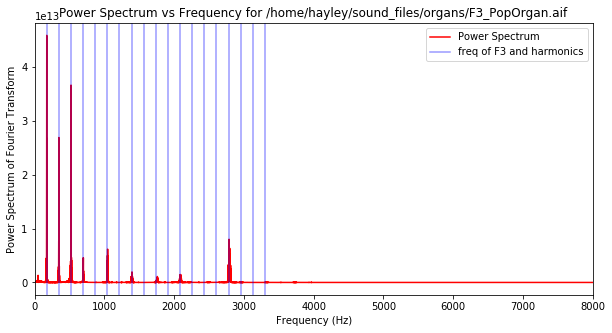

In [18]:
#Demonstration of results on organ file
file = organ_files[0]
find_musical_notes(file)

In [13]:
def find_musical_notes(file):
    int_data, frames, rate_ = read_aif(file) 
    id_note(int_data, frames, rate_, file)

In [14]:
def read_aif(file):
    wf = aifc.open(file)
    data = wf.readframes(wf.getnframes())
    rate_ = wf.getframerate()
    frames = wf.getnframes()
    integer_data = np.fromstring(data, dtype=np.int32).byteswap()
    return integer_data, frames, rate_

In [17]:
def id_note(integer_data, frames, rate_, file):
    """Basic Logic: get the power spectrum of the input data. Look only at the
    numbers corresponding to frequencies between 0 and 8k hertz to avoid some 
    noisy values in the very high frequency range that are out of the range of
    human hearing.
    This script allows for between 1 and 3 notes to be present.
    To decide how many notes are present, take the 15 frequencies corresponding to
    the fifteen highest values of the power spectrum. Find the minimum of these
    frequencies, and decide if all the other 14 frequencies are close enough to an
    integer multiple of that frequency (and thus are harmonics). If they are, there's
    only one note. If they aren't repeat with only the frequencies that weren't
    harmonics of the first note to decide if there are 2 or 3 notes present.
    Then plot the results, and convert the frequencies to notes.
    """
    fft = np.fft.fft(integer_data)
    psd = np.abs(fft)
    #get frequencies that correspond to each item in psd
    freqs = np.arange(0,(1-1/frames)+1/frames,1/frames)*rate_ 
    #0:160000 includes all frequencies within the 0 8000 range of the octaves
    max_inds = psd[0:160000].argsort()[::-1]
    dom_freqs = freqs[max_inds[0:16]]
    #check if all first 15 biggest frequencies are close enough to integer
    #multiples of each other
    #this indicates whether there's probably only one note + its harmonics
    #or multiple notes
    multiple_check = [x/min(dom_freqs) for x in dom_freqs] #divide each by the min
    #then subtract from the integer to get a number between 0 and 1
    multiple_check = [abs(x - round(x)) for x in multiple_check] 
    #if they're all within .25 of an integer multiple, consider it one note
    is_single_note = np.asarray([y<.25 for y in multiple_check]).all() 
    
    fig=plt.figure(figsize= (10,5))
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(freqs,psd, 'r-', label = 'Power Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectrum of Fourier Transform')
    plt.title('Power Spectrum vs Frequency for ' + file)
    
    if not is_single_note:
        dom_freq1 = min(dom_freqs)
        
        #remove harmonics and then check if there are still multiple note present
        dom_freqs = dom_freqs[np.where(np.asarray(multiple_check) > .25)]
        multiple_check = [x/min(dom_freqs) for x in dom_freqs] 
        multiple_check = [abs(x - round(x)) for x in multiple_check] 
        is_two_notes = np.asarray([y<.1 for y in multiple_check]).all()
        
        if not is_two_notes:
            dom_freq2 = min(dom_freqs)
            dom_freq3 = min(dom_freqs[np.where(np.asarray(multiple_check) > .25)])
            print('Three notes found in file ' + file + ' : ' +
                  freq_to_note(dom_freq1) +  ' w/freq ' + str(dom_freq1) +
              ' and ' + freq_to_note(dom_freq2) + ' w/freq ' + str(dom_freq2) +
               ' and ' + freq_to_note(dom_freq3) + ' w/freq ' + str(dom_freq3))
            #draw three lines then the legend
            ax1.axvline(x=dom_freq1*1, color = 'b', alpha=.4,
                        label = 'freq of '+freq_to_note(dom_freq1)+' and harmonics')
            ax1.axvline(x=dom_freq2*1, color = 'g', alpha=.4,
                       label = 'freq of '+freq_to_note(dom_freq2)+' and harmonics')
            ax1.axvline(x=dom_freq3*1, color = 'm', alpha=.4,
                       label = 'freq of '+freq_to_note(dom_freq3)+' and harmonics')
            ax1.legend()
            for i in range(1, 20):
                ax1.axvline(x=dom_freq1*i, color = 'b', alpha=.4)
                ax1.axvline(x=dom_freq2*i, color = 'g', alpha=.4)
                ax1.axvline(x=dom_freq3*i, color = 'm', alpha=.4)
        
        else:
            dom_freq2 = min(dom_freqs)
            print('Two notes found in file ' + file + ' : ' + freq_to_note(dom_freq1)
                  +  ' w/freq ' + str(dom_freq1) +
                  ' and ' + freq_to_note(dom_freq2) + ' w/freq ' + str(dom_freq2))
        
            #draw two lines then the legend
            ax1.axvline(x=dom_freq1*1, color = 'b', alpha=.4,
                        label = 'freq of '+freq_to_note(dom_freq1)+' and harmonics')
            ax1.axvline(x=dom_freq2*1, color = 'g', alpha=.4,
                       label = 'freq of '+freq_to_note(dom_freq2)+' and harmonics')
            ax1.legend()
        
            #draw the rest of the lines now that the legend is created
            for i in range(2, 20):
                line2 = ax1.axvline(x=dom_freq1*i, color = 'b', alpha=.4)
                line3 = ax1.axvline(x=dom_freq2*i, color = 'g', alpha=.4)
        
    else:
        dom_freq = min(dom_freqs)
        print('One note found in file ' + file + ' : ' + freq_to_note(dom_freq)
              + ' w/freq ' + str(dom_freq))
        
        ax1.axvline(x=dom_freq*1, color = 'b', alpha=.4,
                       label = 'freq of '+freq_to_note(dom_freq)+' and harmonics')
        ax1.legend()
        for i in range(2, 20):
            ax1.axvline(x=dom_freq*i, color = 'b', alpha=.4)

    #this is about the range of the 8 octaves of notes I included
    plt.xlim(0, 8000);

In [19]:
def freq_to_note(freq):
    """Convert from frequency to note. Generate a dict of note, frequency pairs
    based on C4 having a frequency of 261.63. Each note is x steps away from C4,
    with x = (4-the octave of the note)*-12 + the order of the note in name. The
    frequency of each note is 261 * 2 ^ (x/12).
    """
    
    name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    note_dict = {}
    for octave in range(0, 9):
        for n_note in range(0,12):
            f = 261.63*pow(2,((4-octave)*-12 + n_note)/12)
            note_name = name[n_note] + str(octave)
            note_dict[f] = note_name

    return note_dict[min(note_dict, key=lambda x:abs(x-freq))]

Program results for audio files:
1 - C4, D4, and G4
2 - F3, freq ~173
3 - A4, freq 433
4 - C4
5- G2 and D3
6 - C5, freq ~520
7 - D5
8 - F4, freq ~547
9 - G3, freq ~ 195
10 - C2, frequency ~65.25
11- E2
12 - C2

Program results for organ files:
F3_PopOrgan.aif : F3 w/freq 173.875
C4+A4_PopOrgan.aif : C4 w/freq 260.9375 and A4 w/freq 437.125
A4_PopOrgan.aif : A4 w/freq 437.125
F4_CathedralOrgan.aif : F4 w/freq 349.0625

Results of reading file incorrectly:
If I read the files as a 16 bit integer instead of a 32 bit integer, the length of the resulting array is twice as long. I had to change some of my code to use the length of the integer array instead of the number of frames for it to work (I changed it back), but it was able to still identify the peaks, but they were half as large as before. This causes all the identified frequencies to be half of their real value, because rate makes it seem like the file is twice as long.
If I read them as an unsigned 32 bit integer, this causes the values of the power spectrum to be much much larger. They were so large that python started rounding the division of them to nan and inf, so I wasn't able to actually check what the programs output would be. However, it looked like the frequency information was the same, just the amplitudes were different, so I would guess that the program would work the same 